In [133]:
import requests
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
def getdata(airline):
    apiKey = "gQvOAvCu725jH4VcgCA300hbQJNwFfz2"
    apiUrl = "https://aeroapi.flightaware.com/aeroapi/"

    operators = airline
    payload = {'max_pages': 5}
    auth_header = {'x-apikey':apiKey}

    response = requests.get(apiUrl + f"operators/{operators}/flights",
    params=payload, headers=auth_header)

    if response.status_code == 200:
        output = response.json()
        return output
    else:
        return("Error executing request")

def getflight(callsign):
    apiKey = "gQvOAvCu725jH4VcgCA300hbQJNwFfz2"
    apiUrl = "https://aeroapi.flightaware.com/aeroapi/"

    flight = str(callsign)
    current_utc_time = datetime.datetime.utcnow()
    utc = current_utc_time.strftime("%Y-%m-%dT%H:%M:%SZ")
    one_day_ago = current_utc_time - datetime.timedelta(days=1)
    utc_1 = one_day_ago.strftime("%Y-%m-%dT%H:%M:%SZ")
    payload = {'max_pages': 4,'start':utc_1,'end':utc}
    auth_header = {'x-apikey':apiKey}

    response = requests.get(apiUrl + f"flights/{flight}",
        params=payload, headers=auth_header)

    if response.status_code == 200:
        output = response.json()
        return output
    else:
        return("Error executing request")
def get_airport_arrivals(airport):
    apiKey = "gQvOAvCu725jH4VcgCA300hbQJNwFfz2"
    apiUrl = "https://aeroapi.flightaware.com/aeroapi/"

    airports = airport
    payload = {'max_pages': 2}
    auth_header = {'x-apikey':apiKey}

    response = requests.get(apiUrl + f"airports/{airports}/flights",
        params=payload, headers=auth_header)

    if response.status_code == 200:
        airport_output = response.json()
    else:
       return("Error executing request")

    airport_arrivals = pd.json_normalize(airport_output['arrivals'])
    airport_arrivals_cleaned=airport_arrivals[["ident_icao","operator","departure_delay","arrival_delay","aircraft_type","route_distance","origin.code_icao","destination.code_icao"]]
    return airport_arrivals_cleaned


In [134]:
flightdata = getflight(input('Input flight callsign. e.g."UAL1"'))
flight = pd.json_normalize(flightdata['flights'])
airline = flight['operator_icao'][0]
departure_delay = flight['departure_delay'][0]
aircraft = flight['aircraft_type'][0]
dist = flight['route_distance'][0]
origin = flight['origin.code_icao'][0]
destination = flight['destination.code_icao'][0]
print(origin)

VHHH


In [135]:
flight_requested = pd.DataFrame({'operator':[airline],'departure_delay':[departure_delay],'aircraft_type':[aircraft],'route_distance':[dist],'origin.code_icao':[origin],'destination.code_icao':[destination],'arrival_delay':[0]})
print(flight_requested)
airline = str(airline)
output = getdata(airline)
scheduled = pd.json_normalize(output['scheduled'])
arrivals = pd.json_normalize(output['arrivals'])
arrivals_cleaned=flight_requested.append(arrivals[["ident_icao","operator","departure_delay","arrival_delay","aircraft_type","route_distance","origin.code_icao","destination.code_icao"]])
destination_airport = get_airport_arrivals(destination)
arrivals_cleaned = arrivals_cleaned.append(destination_airport)
numeric_cols = arrivals_cleaned.select_dtypes(include=[int, float])
arrivals_cleaned[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())
arrivals_cleaned = arrivals_cleaned.fillna('Unknown')
X = arrivals_cleaned[["operator","departure_delay","aircraft_type","route_distance","origin.code_icao","destination.code_icao"]]
y = arrivals_cleaned['arrival_delay']
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X['operator'])
sequences = tokenizer.texts_to_sequences(X['operator'])
max_sequence_length = 20
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')
sequences = np.array(sequences)
X['operator'] = sequences
tokenizer.fit_on_texts(X['aircraft_type'])
sequences = tokenizer.texts_to_sequences(X['aircraft_type'])
max_sequence_length = 20
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')
sequences = np.array(sequences)
X['aircraft_type'] = sequences
tokenizer.fit_on_texts(X['origin.code_icao'])
sequences = tokenizer.texts_to_sequences(X['origin.code_icao'])
max_sequence_length = 20
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')
sequences = np.array(sequences)
X['origin.code_icao'] = sequences
tokenizer.fit_on_texts(X['destination.code_icao'])
sequences = tokenizer.texts_to_sequences(X['destination.code_icao'])
max_sequence_length = 20
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')
sequences = np.array(sequences)
X['destination.code_icao'] = sequences
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=6))  # Input layer with 6 features
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))  # Output layer for regression
model.compile(optimizer='adam', loss='mean_squared_error')  # Use an appropriate loss function for your task
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test))
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
y_pred = model.predict(X_test)


  operator  departure_delay aircraft_type  route_distance origin.code_icao  \
0      CPA             -420          A359            1805             VHHH   

  destination.code_icao  arrival_delay  
0                  RJTT              0  


C:\Users\FJL767\AppData\Local\Temp\ipykernel_21560\566933382.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  arrivals_cleaned=flight_requested.append(arrivals[["ident_icao","operator","departure_delay","arrival_delay","aircraft_type","route_distance","origin.code_icao","destination.code_icao"]])


Epoch 1/1000


C:\Users\FJL767\AppData\Local\Temp\ipykernel_21560\566933382.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  arrivals_cleaned = arrivals_cleaned.append(destination_airport)
C:\Users\FJL767\AppData\Local\Temp\ipykernel_21560\566933382.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['operator'] = sequences
C:\Users\FJL767\AppData\Local\Temp\ipykernel_21560\566933382.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

3/3 [==============================] - 0s 49ms/step - loss: 28650966.0000 - val_loss: 9780407.0000
Epoch 2/1000
3/3 [==============================] - 0s 10ms/step - loss: 28650280.0000 - val_loss: 9780095.0000
Epoch 3/1000
3/3 [==============================] - 0s 12ms/step - loss: 28649734.0000 - val_loss: 9779781.0000
Epoch 4/1000
3/3 [==============================] - 0s 17ms/step - loss: 28648982.0000 - val_loss: 9779452.0000
Epoch 5/1000
3/3 [==============================] - 0s 15ms/step - loss: 28648266.0000 - val_loss: 9779135.0000
Epoch 6/1000
3/3 [==============================] - 0s 17ms/step - loss: 28647698.0000 - val_loss: 9778791.0000
Epoch 7/1000
3/3 [==============================] - 0s 16ms/step - loss: 28646866.0000 - val_loss: 9778462.0000
Epoch 8/1000
3/3 [==============================] - 0s 16ms/step - loss: 28646342.0000 - val_loss: 9778093.0000
Epoch 9/1000
3/3 [==============================] - 0s 16ms/step - loss: 28645428.0000 - val_loss: 9777727.0000
Epoch

In [136]:
print(arrivals_cleaned)

   operator  departure_delay aircraft_type  route_distance origin.code_icao  \
0       CPA             -420          A359            1805             VHHH   
0       CPA               60          A359            1843             RJAA   
1       CPA               60          B773            1059             RJBB   
2       CPA              780          B773            1287             RKSI   
3       CPA                0          A359            4599             YSSY   
..      ...              ...           ...             ...              ...   
25      ADO                0          B763             434             RJCH   
26      JAL             4320          B77W            5966             EGLL   
27      ANA              -60          A320             169             RJTH   
28      JAL              840          B77W            7584             KJFK   
29      ANA              960           787             251             RJOO   

   destination.code_icao  arrival_delay ident_icao 

In [137]:
print(y_pred)

[[ 1072.0798 ]
 [ -387.5335 ]
 [  711.26166]
 [ 2904.4568 ]
 [  290.52167]
 [ 1054.723  ]
 [ -405.5772 ]
 [11582.716  ]
 [  892.1552 ]
 [ -691.8791 ]
 [   76.81487]
 [-1094.8032 ]
 [-1029.3296 ]
 [ 1651.6533 ]
 [ -675.99176]
 [ -382.17303]
 [ -190.44173]
 [ 1138.459  ]
 [ -785.5264 ]
 [ -608.7915 ]
 [ -369.0661 ]
 [ 1703.7859 ]]


In [138]:
print(y_test)

24     1620
9       180
3      2460
5      3000
21        0
64     3325
29     -300
32    10195
17     1260
10     -180
46     8505
41      240
0         0
2       720
17      180
63      720
66      120
3      1620
54     -780
43       60
11      191
4      2001
Name: arrival_delay, dtype: int64


In [139]:
print(X_test)

[[ 8.33568207e-01 -7.37843148e-02  9.54138504e-01 -8.46300266e-01
   1.96371013e-01 -5.46150823e-01]
 [-4.51197470e-01 -1.72443981e-01 -7.61083242e-01 -3.10242544e-01
  -1.08443004e+00 -4.83319313e-03]
 [-4.51197470e-01 -2.46438731e-01 -7.61083242e-01  1.40348639e+00
   2.31024721e-03 -5.79983175e-01]
 [ 8.33568207e-01  3.57851725e-01 -7.61083242e-01 -4.75820219e-01
   1.43835992e+00 -5.46150823e-01]
 [ 1.91185369e-01 -2.46438731e-01  9.54138504e-01 -7.71272882e-01
  -2.69374825e-01 -5.46150823e-01]
 [-4.51197470e-01 -6.16206938e-01 -1.37366244e-01  2.51026966e+00
  -3.46999131e-01 -5.79983175e-01]
 [-4.51197470e-01 -2.58771189e-01 -2.93295493e-01 -5.72062242e-01
  -1.08443004e+00 -7.24978969e-02]
 [-4.51197470e-01  1.79396649e+00 -1.37366244e-01  1.02162288e+00
   9.33801924e-01 -1.73994953e-01]
 [ 1.91185369e-01 -8.61167731e-02  3.30421505e-01 -8.00766405e-01
   1.71004499e+00 -5.46150823e-01]
 [-4.51197470e-01 -3.57430855e-01 -9.17012492e-01 -5.72062242e-01
  -1.08443004e+00 -7.2497

In [140]:
flight_requested = pd.DataFrame({'operator':[airline],'departure_delay':[departure_delay],'aircraft_type':[aircraft],'route_distance':[dist],'origin.code_icao':[origin],'destination.code_icao':[destination],'arrival_delay':[0]})
print(flight_requested)


  operator  departure_delay aircraft_type  route_distance origin.code_icao  \
0      CPA             -420          A359            1805             VHHH   

  destination.code_icao  arrival_delay  
0                  RJTT              0  


In [141]:
flight_to_predict = scaler.fit_transform(X)
ETA = model.predict(flight_to_predict)
print("The estimated delay of this flight, in seconds, is:",ETA[0][0])

4/4 [==============================] - 0s 2ms/step
The estimated delay of this flight, in seconds, is: -1033.2162


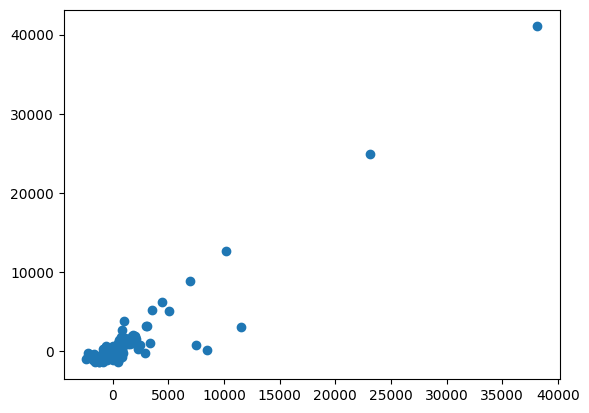

In [150]:
ETA_new = []
for i in range(len(ETA)):
    ETA_new.append(ETA[i][0])
ATA = arrivals_cleaned['arrival_delay']
plt.scatter(ATA,ETA_new)
plt.xlabel='Actual Delay'
plt.ylabel='Estimated Delay'
